In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
import scipy
import os
import glob
import seaborn as sns
import itertools
import gc
import pickle
from nptdms import TdmsFile
from scipy import stats
from natsort import natsorted
from tqdm import tqdm

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
import scienceplots

matplotlib.rcParams['text.usetex'] = True
plt.rcParams["text.usetex"] = True
# import seaborn as sns
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.interpolate import make_interp_spline, BSpline

np.random.seed(16)
matplotlib.rcParams['figure.dpi'] = 300

plt.style.use(['science','nature'])
plt.rcParams['figure.constrained_layout.use'] = True

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(["Open","Arc","Short","Normal"])

import sys
sys.path.append('../.')
# from pydub import AudioSegment
import itertools
import string
import glob
import subprocess
import seedir
from utils.preprocessing import one_column,two_column,cm_std,cm_bright,cm_mark,cm_highCon,centimeter
from utils.preprocessing import print_tdms_structure,split_pulses_by_interval,getShiftMean
mpl.rcParams.update(two_column)

alphabet = list(string.ascii_lowercase)
sampling_rate = 10000000

In [ ]:
# time_series_length=[1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000]
allowed_input_types=[
    'ae_spec',
    'ae_features',
    'ae_features+pp',
    'ae_spec+ae_features',

    'vib_spec',
    'vib_features',
    'vib_features+pp',
    'vib_spec+vib_features',

    'ae_spec+ae_features+vib_spec+vib_features',

    'all',
]

    # 'ae_spec+vib_spec',
    # 'ae_features+vib_features',
    # 'ae_features+vib_features+pp',


In [3]:
def get_hist_data(hist_dir, input_type, repeat, folds, max_epochs=100):
    train_mae = []
    test_mae = []
    train_mse = []
    test_mse = []
    for i in range(int(folds*repeat)):
        file_path = f"{input_type}_fold{i}_of_folds{folds}.csv"
        file_path = os.path.join(hist_dir, file_path)
        # print(f"{file_path}")
        # print(f"{file_path},{os.listdir(file_path)}")
        df = pd.read_csv(file_path, index_col=0)
        df = df[~df.index.get_level_values(0).duplicated(keep="last")]
        train_mse.append((df["train_mse"][max_epochs]))
        test_mse.append((df["test_mse"][max_epochs]))
        train_mae.append((df["train_mae"][max_epochs]))
        test_mae.append((df["test_mae"][max_epochs]))
    return train_mse, test_mse, train_mae, test_mae


def generate_hist_df(
    hist_dir, allowed_input_types, repeat, folds, max_epochs, _s=0.1
):
    train_mse_list = []
    test_mse_list = []
    train_mae_list = []
    test_mae_list = []
    fold_i_list = []
    model_list = []

    for _input_type in allowed_input_types:
        train_mse, test_mse, train_mae, test_mae = get_hist_data(
            hist_dir, _input_type,repeat, folds, max_epochs
        )
        for i in range(folds):
            fold_i_list.append(i)
            train_mae_list.append(train_mae[i]*_s)
            test_mae_list.append(test_mae[i]*_s)
            train_mse_list.append(train_mse[i]*_s)
            test_mse_list.append(test_mse[i]*_s)
            model_list.append(_input_type)

    df = pd.DataFrame()
    df["Input Type"] = model_list
    df["Train MAE"] = train_mae_list
    df["Test MAE"] = test_mae_list
    df["Train MSE"] = train_mse_list
    df["Test MSE"] = test_mse_list
    df["Fold index"] = fold_i_list

    new_df = pd.concat([df, df])
    new_df["MAE"] = pd.concat([df["Train MAE"], df["Test MAE"]])
    new_df["MAE type"] = ["Train"] * len(df) + ["Test"] * len(df)
    new_df.index = range(len(new_df))
    df = new_df

    new_df = pd.concat([df, df])
    new_df["MSE"] = pd.concat([df["Train MSE"], df["Test MSE"]])
    new_df["MSE type"] = ["Train"] * len(df) + ["Test"] * len(df)
    new_df.index = range(len(new_df))
    return new_df

In [4]:
max_epochs=19
his_dir = os.path.join("../lfs","train_his")
# context_type = ['energy']
folds = 10

df = generate_hist_df(his_dir,allowed_input_types=allowed_input_types,folds=folds,repeat=10, max_epochs=max_epochs)

In [5]:
df

,Input Type,Train MAE,Test MAE,Train MSE,Test MSE,Fold index,MAE,MAE type,MSE,MSE type
0,ae_spec,13.348607,9.975049,1741.571245,1385.637817,0,13.348607,Train,1741.571245,Train
1,ae_spec,10.257385,8.164131,1010.057339,1289.233844,1,10.257385,Train,1010.057339,Train
2,ae_spec,9.508212,8.546850,1137.197109,1345.699109,2,9.508212,Train,1137.197109,Train
3,ae_spec,3.393739,6.667473,842.607230,900.177002,3,3.393739,Train,842.607230,Train
4,ae_spec,7.187405,11.827900,1575.195713,2206.241284,4,7.187405,Train,1575.195713,Train
...,...,...,...,...,...,...,...,...,...,...
395,all,5.313690,4.574652,1026.347726,488.232379,5,4.574652,Test,488.232379,Test
396,all,2.072436,4.833253,461.670943,872.444351,6,4.833253,Test,872.444351,Test
397,all,1.817060,3.483322,484.421240,532.977769,7,3.483322,Test,532.977769,Test
398,all,5.534109,3.124278,490.212634,291.342822,8,3.124278,Test,291.342822,Test


/tmp/ipykernel_32729/3092475153.py:5: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.violinplot(
/tmp/ipykernel_32729/3092475153.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([('\n').join(x.split('_')) for x in xTickLabels])
/tmp/ipykernel_32729/3092475153.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{x*1:.0f}\%' for x in ax.get_yticks()[:-2]])


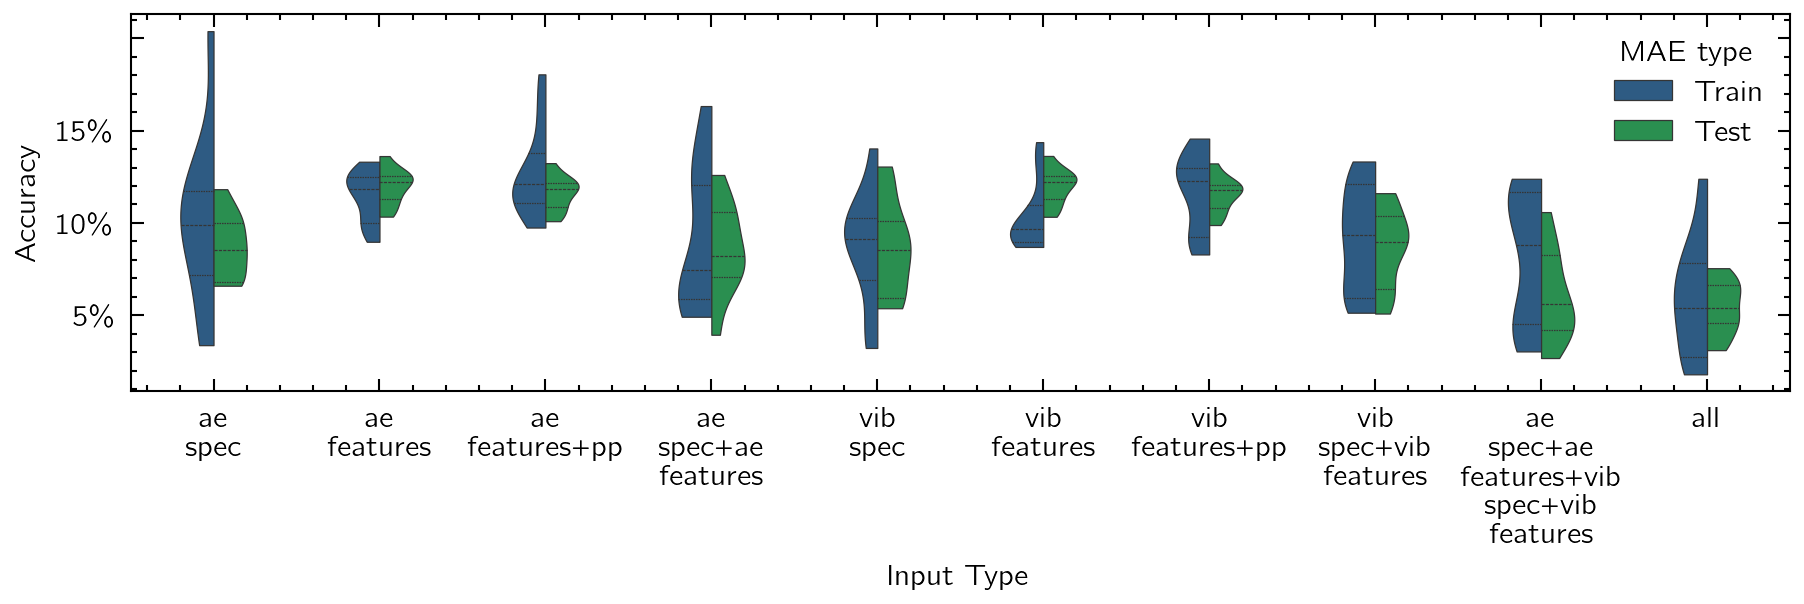

In [6]:
plt.rcParams.update(one_column)
plt.rcParams['figure.constrained_layout.use'] = True
fig,ax = plt.subplots(figsize=(6.0,2))
snsdf = sns.load_dataset("tips")
ax = sns.violinplot(
    # data=df[df["Model"]=="CNN"],
    data=df,
    x="Input Type",
    y="MAE",
    hue="MAE type",
    split=True,
    saturation=0.55,
    density_norm="width",
    hue_order=["Train", "Test"],
    dodge=True,
    inner='quartile',
    ax=ax,
    linewidth=0.3,
    width = 0.4,
    palette = ['#0C5DA5', '#00B945', 'yellow'],
    cut = 0,
)

xTickLabels = allowed_input_types
ax.set_xticklabels([('\n').join(x.split('_')) for x in xTickLabels]) 
ax.set_yticklabels([f'{x*1:.0f}\%' for x in ax.get_yticks()[:-2]]) 

# xTickLabels = model_name
# ax.set_xticklabels([x for x in xTickLabels]) 
ax.set_ylabel("Accuracy")
# plt.savefig(os.path.join(os.pardir,"CIRP ISEM 2025","image","raw_acc_vs_model.png"),dpi=300)
plt.savefig(os.path.join(os.pardir,"Grinding Fusion","images",f"raw_MAE_vs_model.png"),dpi=300)

plt.show()

/tmp/ipykernel_32729/3203252831.py:5: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.violinplot(
/tmp/ipykernel_32729/3203252831.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([('\n').join(x.split('_')) for x in xTickLabels])


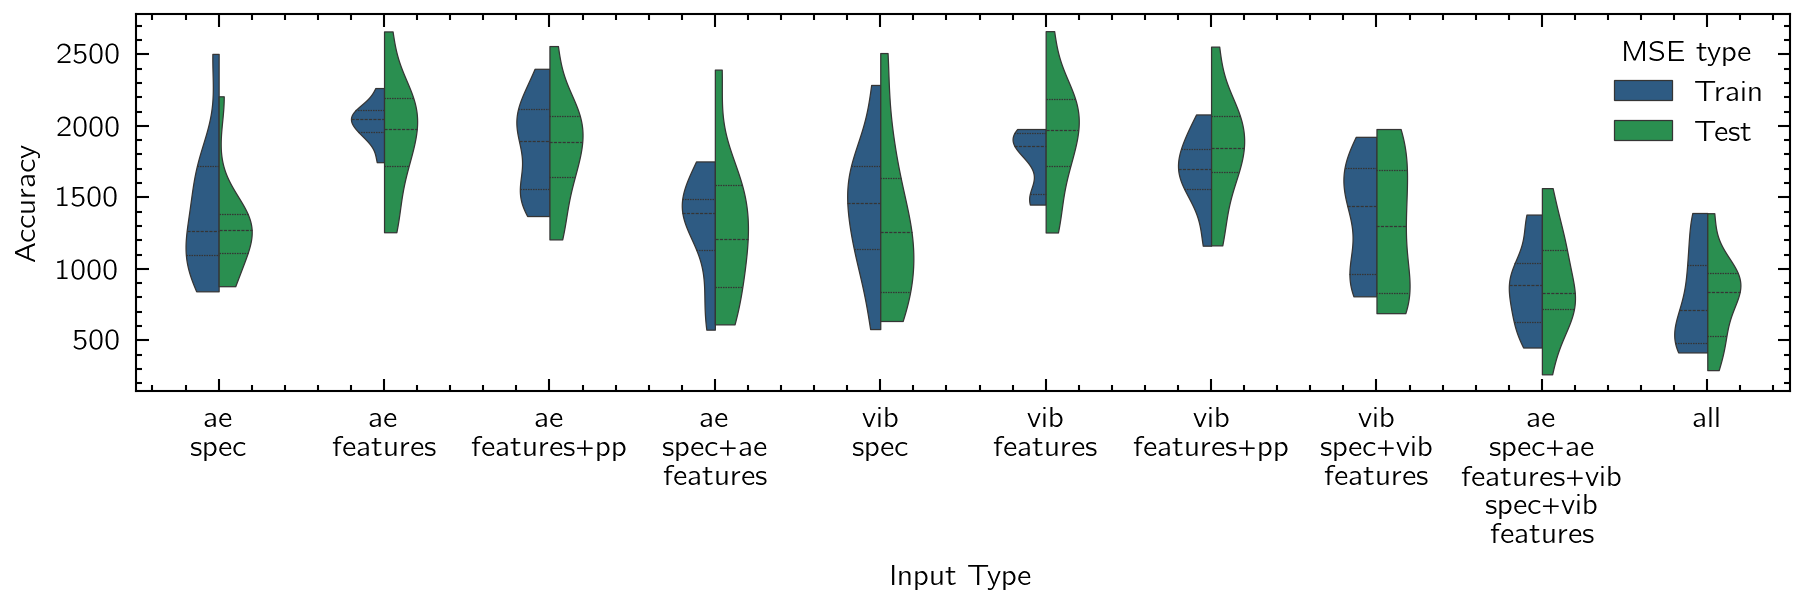

In [7]:
plt.rcParams.update(one_column)
plt.rcParams['figure.constrained_layout.use'] = True
fig,ax = plt.subplots(figsize=(6.0,2))
snsdf = sns.load_dataset("tips")
ax = sns.violinplot(
    # data=df[df["Model"]=="CNN"],
    data=df,
    x="Input Type",
    y="MSE",
    hue="MSE type",
    split=True,
    saturation=0.55,
    density_norm="width",
    hue_order=["Train", "Test"],
    dodge=True,
    inner='quartile',
    ax=ax,
    linewidth=0.3,
    width = 0.4,
    palette = ['#0C5DA5', '#00B945', 'yellow'],
    cut = 0,
)
# ax.set_yticklabels([f'{x*1:.0f}\%' for x in ax.get_yticks()[:-2]]) 
# xTickLabels = model_name
# ax.set_xticklabels([x for x in xTickLabels]) 
xTickLabels = allowed_input_types
ax.set_xticklabels([('\n').join(x.split('_')) for x in xTickLabels]) 
ax.set_ylabel("Accuracy")
plt.savefig(os.path.join(os.pardir,"Grinding Fusion","images",f"raw_MSE_vs_model.png"),dpi=300)
plt.show()